In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap
import warnings
import urllib.request
from PIL import Image
%matplotlib inline

warnings.filterwarnings("ignore")

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [2]:
soloq_games_euw = pd.read_csv("../data/soloq/Europe_stats.csv")
soloq_games_kr = pd.read_csv("../data/soloq/Asia_stats.csv")

soloq_games = pd.concat([soloq_games_euw, soloq_games_kr])

soloq_games = soloq_games.dropna()
# delete games with < 15 mins
soloq_games = soloq_games[soloq_games['gameEndedInEarlySurrender'] == False]
# creates a patch column
soloq_games['patch'] = soloq_games.apply(lambda x: str(x['gameVersion'].split('.')[0] + '.' + x['gameVersion'].split('.')[1]), axis=1 )

relevant_cols = [
    "patch", "teamPosition", "championId", "championName", "gameDuration", "win",
    "neutralMinionsKilled", "totalMinionsKilled", "cs_diff_at_15",
    "champExperience", "xp_diff", "xp_diff_per_min", "xp_per_min_3_15",
    "damageDealtToBuildings", "damageDealtToObjectives", "damageDealtToTurrets", "damageSelfMitigated", "magicDamageDealt", "magicDamageDealtToChampions", "magicDamageTaken",
    "physicalDamageDealt", "physicalDamageDealtToChampions", "physicalDamageTaken", "totalDamageDealt", "totalDamageDealtToChampions", "totalDamageShieldedOnTeammates",
    "totalDamageTaken", "totalHeal", "totalHealsOnTeammates", "totalUnitsHealed", "trueDamageDealt", "trueDamageDealtToChampions", "trueDamageTaken",
    "totalTimeCCDealt", "timeCCingOthers", "totalTimeSpentDead", "dmg_per_minute_diff", "dmg_per_minute_diff_15", "kills", "deaths", "assists", "kill_share", "kill_participation",
    "doubleKills", "tripleKills", "quadraKills", "pentaKills", "firstBloodAssist", "firstBloodKill", "killingSprees", "largestKillingSpree", "largestMultiKill",
    "goldEarned", "goldSpent", "gold_share", "gold_earned_per_min", "gold_diff_15", "gold_10k_time",
    "inhibitorKills", "inhibitorTakedowns", "inhibitorsLost", 
    "itemsPurchased", "consumablesPurchased",
    "largestCriticalStrike", "longestTimeSpentLiving",
    "firstTowerAssist", "firstTowerKill", "objectivesStolen", "objectivesStolenAssists", "turretKills", "turretTakedowns", "turretsLost",
    "sightWardsBoughtInGame", "visionScore", "visionWardsBoughtInGame", "detectorWardsPlaced", "wardsKilled", "wardsPlaced",
    "spell1Casts", "spell2Casts", "spell3Casts", "spell4Casts", "summoner1Casts", "summoner2Casts",
    "lane_proximity", "jungle_proximity", "percent_mid_lane", "percent_side_lanes", "forward_percentage", "counter_jungle_time_percentage",
]


# select only relevant cols
soloq = soloq_games[ relevant_cols ]


In [3]:

def clean_data(df, role = "None", patch = "All", stratified_sampling = False):
    games_df = df
    if patch != "All":
        games_df = games_df[ games_df['patch'] == patch]
    else:
        games_df = games_df
        
    if role != "None":
        games_df = games_df[ games_df['teamPosition'] == role ]
    else:
        games_df = games_df
    # list of champions with more than 100 games played
    top_champs = [i for i, x in games_df.championName.value_counts().to_dict().items() if x > 100]
    games_df = games_df[games_df['championName'].isin(top_champs)]
    if stratified_sampling:
        games_df = games_df.groupby(by='championName').apply(lambda x: x.sample(n=100)).reset_index(level=1, drop=True).drop(['championName'], axis=1).reset_index()
    try:
        games_df = games_df.drop(['teamPosition'], axis=1)
        games_df = games_df.drop(['patch'], axis=1)
        games_df = games_df.drop(['Unnamed: 0'], axis=1)
    except Exception as e:
        print(e)
    return games_df

def kmeans_clustering_elbow(df, total_k = 20):
    distorsions = []
    K = range(1, total_k)
    for k in K:
        kmean_model = KMeans(n_clusters=k)
        kmean_model.fit(df)
        distorsions.append(kmean_model.inertia_)
        
    plt.figure(figsize=(16,8))
    plt.plot(K, distorsions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
def group_by_champions(df):
    df_champs = df.drop(['championId'], axis=1).groupby("championName").mean().reset_index(level=0)
    x = df_champs.iloc[:,1:]
    y = df_champs.iloc[:,:1]
    return x, y

def pca_kmeans(soloq, role="None", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 2 ):
    role_soloq = clean_data(soloq, role=role, patch=patch, stratified_sampling = stratified_sampling)
    x_role, y_role = group_by_champions(role_soloq)
    ## standarize
    role_std_model = StandardScaler()
    x_role_std = role_std_model.fit_transform(x_role)
    ## pca
    pca = PCA( variance_explained_specified )
    role_principal_components = pca.fit_transform(x_role_std)
    ## k-means
    # kmeans_clustering_elbow(role_principal_components, total_k = 20)
    role_kmeans_model = KMeans(n_clusters= k ).fit(role_principal_components)
    y_role['kmeans'] = role_kmeans_model.predict(role_principal_components)
    y_role
    role_champions_list = y_role.groupby('kmeans')['championName'].apply(list).to_dict()
    
    return y_role, role_champions_list, role_principal_components

def umap_kmeans(soloq, role="None", patch="12.5", stratified_sampling = False, n_comps= 2 , k = 2 ):
    role_soloq = clean_data(soloq, role=role, patch=patch, stratified_sampling = stratified_sampling)
    x_role, y_role = group_by_champions(role_soloq)
    ## standarize
    role_std_model = StandardScaler()
    x_role_std = role_std_model.fit_transform(x_role)
    ## umap
    reducer = umap.UMAP(n_components= n_comps)
    role_umap = reducer.fit_transform(x_role_std)
    ## k-means
    # kmeans_clustering_elbow(role_umap, total_k = 20)
    role_kmeans_model = KMeans(n_clusters= k ).fit(role_umap)
    y_role['kmeans'] = role_kmeans_model.predict(role_umap)
    role_champions_list = y_role.groupby('kmeans')['championName'].apply(list).to_dict()
    
    return y_role, role_champions_list, role_umap

def print_kmeans(y_role):
    for category in pd.unique(y_role['kmeans']):
        print(category)
        for champion in pd.unique(y_role[y_role['kmeans'] == category]['championName']):
            print(champion)
        print("")

### pca

In [4]:
y_global_pca, pca_global_champions_list, global_principal_components = pca_kmeans(soloq, role="None", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 4 )
y_top_pca, pca_top_champions_list, top_principal_components = pca_kmeans(soloq, role="TOP", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 2 )
y_jungle_pca, pca_jungle_champions_list, jungle_principal_components = pca_kmeans(soloq, role="JUNGLE", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 3 )
y_mid_pca, pca_mid_champions_list, mid_principal_components = pca_kmeans(soloq, role="MIDDLE", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 4 )
y_bottom_pca, pca_bottom_champions_list, bottom_principal_components = pca_kmeans(soloq, role="BOTTOM", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 5 )
y_utility_pca, pca_utility_champions_list, utility_principal_components = pca_kmeans(soloq, role="UTILITY", patch="12.5", stratified_sampling = False, variance_explained_specified=0.85, k = 3 )

"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"


In [5]:
print("global:")
print_kmeans(y_global_pca)
print("top:")
print_kmeans(y_top_pca)
print("jungle:")
print_kmeans(y_jungle_pca)
print("mid:")
print_kmeans(y_mid_pca)
print("bottom:")
print_kmeans(y_bottom_pca)
print("utility:")
print_kmeans(y_utility_pca)


global:
3
Aatrox
Akshan
Aphelios
Ashe
Caitlyn
Camille
Darius
Draven
Ezreal
Fiora
Gangplank
Garen
Gnar
Graves
Gwen
Illaoi
Irelia
Jax
Jayce
Jhin
Jinx
Kaisa
Kalista
Kayle
KogMaw
Lucian
MissFortune
MonkeyKing
Pantheon
Quinn
Renekton
Riven
Samira
Sion
Sivir
Teemo
Tristana
Tryndamere
Twitch
Urgot
Varus
Vayne
Xayah
Yasuo
Yone
Zeri
Ziggs

2
Ahri
Akali
Anivia
AurelionSol
Azir
Brand
Cassiopeia
Chogath
Corki
Fizz
Galio
Gragas
Karthus
Kassadin
Katarina
Kennen
Leblanc
Lissandra
Malphite
Neeko
Orianna
Ornn
Rumble
Ryze
Shen
Singed
Sylas
Syndra
TwistedFate
Veigar
Velkoz
Vex
Viktor
Vladimir
Xerath
Zoe

1
Alistar
Bard
Blitzcrank
Braum
Ivern
Janna
Karma
Leona
Lulu
Lux
Maokai
Morgana
Nami
Nautilus
Pyke
Rakan
Rell
Renata
Senna
Seraphine
Sett
Sona
Soraka
TahmKench
Thresh
Yuumi
Zilean

0
Diana
Ekko
Elise
Evelynn
FiddleSticks
Hecarim
JarvanIV
Kayn
Khazix
Kindred
LeeSin
Lillia
MasterYi
Nidalee
Nocturne
Nunu
Olaf
Poppy
Qiyana
Rammus
RekSai
Rengar
Shaco
Shyvana
Taliyah
Talon
Trundle
Udyr
Vi
Viego
Volibear
Warwic

### umap

In [6]:
y_global_umap, umap_global_champions_list, global_umap = umap_kmeans(soloq, role="None", patch="12.5", stratified_sampling = False, n_comps= 2, k = 4 )
y_top_umap, umap_top_champions_list, top_umap = umap_kmeans(soloq, role="TOP", patch="12.5", stratified_sampling = False, n_comps= 2, k = 4 )
y_jungle_umap, umap_jungle_champions_list, jungle_umap = umap_kmeans(soloq, role="JUNGLE", patch="12.5", stratified_sampling = False, n_comps= 2, k = 4 )
y_mid_umap, umap_mid_champions_list, mid_umap = umap_kmeans(soloq, role="MIDDLE", patch="12.5", stratified_sampling = False, n_comps= 2, k = 4 )
y_bottom_umap, umap_bottom_champions_list, bottom_umap = umap_kmeans(soloq, role="BOTTOM", patch="12.5", stratified_sampling = False, n_comps= 2, k = 5 )
y_utility_umap, umap_utility_champions_list, utility_umap = umap_kmeans(soloq, role="UTILITY", patch="12.5", stratified_sampling = False, n_comps= 2, k = 4 )

"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"


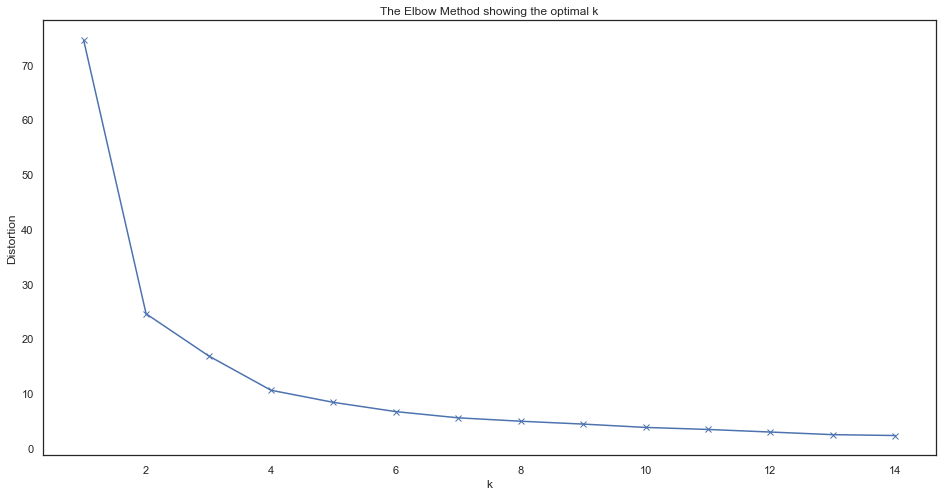

In [7]:
kmeans_clustering_elbow(utility_umap, total_k = 15)

In [8]:

# kmeans_clustering_elbow(top_umap, total_k = 10)

print("global:")
print_kmeans(y_global_umap)
print("top:")
print_kmeans(y_top_umap)
print("jungle:")
print_kmeans(y_jungle_umap)
print("mid:")
print_kmeans(y_mid_umap)
print("bottom:")
print_kmeans(y_bottom_umap)
print("utility:")
print_kmeans(y_utility_umap)

global:
2
Aatrox
Akshan
Aphelios
Ashe
Caitlyn
Camille
Darius
Draven
Ezreal
Fiora
Gangplank
Garen
Gnar
Graves
Gwen
Illaoi
Irelia
Jax
Jayce
Jhin
Jinx
Kaisa
Kalista
KogMaw
Lucian
MasterYi
MissFortune
MonkeyKing
Pantheon
Quinn
Renekton
Riven
Samira
Sion
Sivir
Teemo
Tristana
Tryndamere
Twitch
Urgot
Varus
Vayne
Xayah
Yasuo
Yone
Zeri
Ziggs

3
Ahri
Akali
Anivia
AurelionSol
Azir
Brand
Cassiopeia
Chogath
Corki
Ekko
Fizz
Galio
Karthus
Kassadin
Katarina
Kayle
Kennen
Leblanc
Lissandra
Neeko
Orianna
Rumble
Ryze
Sylas
Syndra
TwistedFate
Veigar
Velkoz
Vex
Viktor
Vladimir
Xerath
Zoe

1
Alistar
Bard
Blitzcrank
Braum
Ivern
Janna
Karma
Leona
Lulu
Lux
Maokai
Morgana
Nami
Nautilus
Pyke
Rakan
Rell
Renata
Senna
Seraphine
Sona
Soraka
TahmKench
Thresh
Yuumi
Zilean

0
Diana
Elise
Evelynn
FiddleSticks
Gragas
Hecarim
JarvanIV
Kayn
Khazix
Kindred
LeeSin
Lillia
Malphite
Nidalee
Nocturne
Nunu
Olaf
Ornn
Poppy
Qiyana
Rammus
RekSai
Rengar
Sett
Shaco
Shen
Shyvana
Singed
Taliyah
Talon
Trundle
Udyr
Vi
Viego
Volibear
Warwic